# Conditional Class Performance

Basic Modules:

In [2]:
import pandas
from pandas import DataFrame, Series
pandas.options.display.max_columns = None

import time
import copy

import matplotlib.pyplot as plt
%matplotlib inline

from itertools import combinations

#### Import Data File:
The data representation indicates student failing a class (1) or student passing a class (0)

In [3]:
df = pandas.read_excel('Class_Bundle_Sample_File.xlsx')

print(df.shape)

df.head()


(99, 11)


,EMPLID,CL1,CL2,CL3,CL4,CL5,CL6,CL7,CL8,CL9,CL10
0,1,1,0,0,0,0,1,1,0,0,0
1,2,0,1,1,1,1,1,0,0,0,1
2,3,1,0,0,0,0,1,1,0,0,1
3,4,0,1,0,1,1,1,0,1,1,0
4,5,0,1,0,1,0,0,0,1,1,0


##### Create all possible combinations of n classes

In [4]:
n = 3

classes = df.columns[1:]

comb = combinations(classes, n) 

comb_list = list(comb)

print('there are {} possible {}-class combinations'.format(len(comb_list), n))

there are 120 possible 3-class combinations


### Prepare data for processing

###### Fix the EMPLID column name which contains a space inserted at the end for no obvious reason.

In [5]:
df.columns

Index(['EMPLID ', 'CL1', 'CL2', 'CL3', 'CL4', 'CL5', 'CL6', 'CL7', 'CL8',
       'CL9', 'CL10'],
      dtype='object')

In [6]:
df.rename(columns={'EMPLID ':'EMPLID'},inplace=True)

## Engine

In [7]:
def combination_counter(df):
    
    #set up rows,columns,indexes and data to populate adjecency matrix
    dim = df.columns[1:].shape[0]
    row = 0
    col = 0
    row_idx = []
    col_idx = []
    data = []
    students = {}
    combo_dict = {}

    lst_index = list(range(dim - 1))
    start = 0
    end = start + len(list(range(dim))) - 1

    for row in range(dim):

        col = row + 1

        if row > 0:

            holder_index = lst_index

            start = holder_index[-1] + 1

            end = start + len(holder_index) - 1

            lst_index = list(range(start,end))

        # iterate through all possible class-combos combos
        for combo in comb_list[start:end]:

            # test
            #print(row,col,combo)

            # end indexing when reaching end
            if col <= end:

                # pull enrollment indicator for class-combos
                df_tuple = df[['EMPLID'] + list(combo)]

                # ignore class-combos without students in common
                if df_tuple[(df_tuple.iloc[:,1]==1) & 
                            (df_tuple.iloc[:,2]==1) & 
                            (df_tuple.iloc[:,3]==1)].shape[0]!=0:

                    # pull df of all students in common for a given class-combo
                    common_stdts_emplid = df_tuple[(df_tuple.iloc[:,1]==1) & 
                                                   (df_tuple.iloc[:,2]==1) & 
                                                   (df_tuple.iloc[:,3]==1)]
                    common_stdts = common_stdts_emplid.drop(columns=['EMPLID'])

                    # count students in common for a given class-combo
                    common_stdts_cnt = common_stdts.iloc[:,0].sum()

                    # store row index
                    row_idx.append(row)

                    # store column index
                    col_idx.append(col)

                    # store students in common count
                    data.append(common_stdts_cnt)

                    # store students in common with emplid
                    students[combo] = common_stdts_emplid

                    # store index class-combos
                    combo_dict[combo] = [combo[0],combo[1],combo[2],row,col,common_stdts_cnt]

                    #test
                    #print(row,col,combo,common_stdts_cnt)

                # accumulate col by one
                col += 1
                
    return (combo_dict,students,data)

###### Implement Engine and obtain results

In [8]:
start_time = time.time()
combo_dict, students, data = combination_counter(df)
end_time = time.time()

print('run took {:0.3f} seconds'.format((end_time-start_time)))

run took 0.154 seconds


In [9]:
print('there are {} class-tuples that have at least one student failing all n classes'.format(len(data)))

print('the maximum number of students enrolled in a class set is {}'.format(max(data)))

there are 45 class-tuples that have at least one student failing all n classes
the maximum number of students enrolled in a class set is 19


In [10]:
combo_data = pandas.DataFrame.from_dict(combo_dict, orient='index')
combo_data.columns = ['class1','class2','class3','row','column','failed']

combo_data.sort_values(by='failed',ascending=False,inplace=True)

combo_data.head()

,class1,class2,class3,row,column,failed
"(CL1, CL2, CL7)",CL1,CL2,CL7,0,5,19
"(CL2, CL3, CL7)",CL2,CL3,CL7,6,7,19
"(CL2, CL3, CL5)",CL2,CL3,CL5,5,8,19
"(CL1, CL7, CL9)",CL1,CL7,CL9,4,6,19
"(CL1, CL3, CL7)",CL1,CL3,CL7,1,4,19


In [29]:
combo_data.shape

(45, 6)

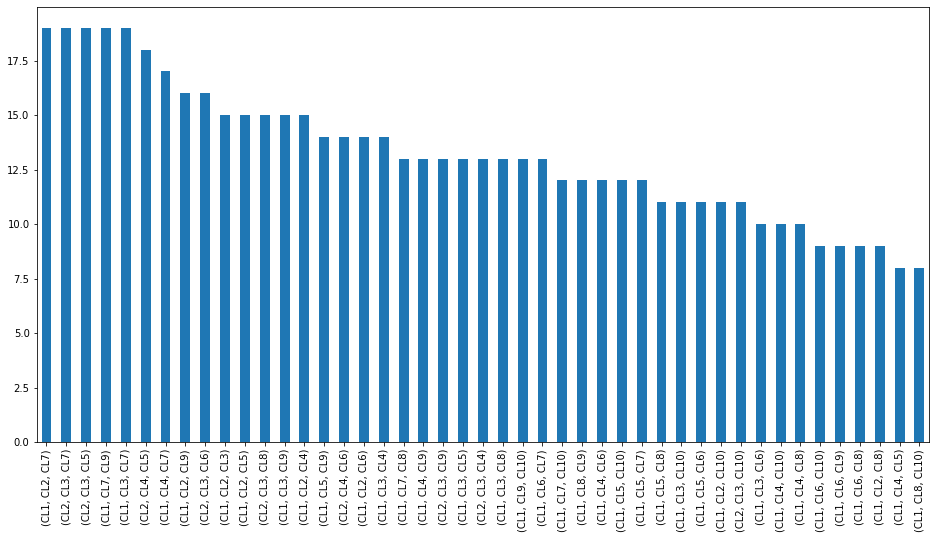

In [27]:
ax = plt.gca()

combo_data['failed'].plot(
    kind='bar',
    figsize=(16,8),
    ax=ax
)

plt.show()

###### Validation:
Look at original dataset and manually count events

In [11]:
df[['CL1','CL2','CL7']].sort_values(by=['CL1','CL2','CL7'],ascending=False).head(20)

,CL1,CL2,CL7
9,1,1,1
11,1,1,1
12,1,1,1
14,1,1,1
18,1,1,1
23,1,1,1
28,1,1,1
31,1,1,1
37,1,1,1
59,1,1,1


In [28]:
students[('CL1', 'CL2', 'CL7')]

,EMPLID,CL1,CL2,CL7
9,10,1,1,1
11,12,1,1,1
12,13,1,1,1
14,15,1,1,1
18,19,1,1,1
23,24,1,1,1
28,29,1,1,1
31,32,1,1,1
37,38,1,1,1
59,60,1,1,1


In [18]:
students.keys()

dict_keys([('CL1', 'CL2', 'CL3'), ('CL1', 'CL2', 'CL4'), ('CL1', 'CL2', 'CL5'), ('CL1', 'CL2', 'CL6'), ('CL1', 'CL2', 'CL7'), ('CL1', 'CL2', 'CL8'), ('CL1', 'CL2', 'CL9'), ('CL1', 'CL2', 'CL10'), ('CL1', 'CL3', 'CL4'), ('CL1', 'CL3', 'CL5'), ('CL1', 'CL3', 'CL6'), ('CL1', 'CL3', 'CL7'), ('CL1', 'CL3', 'CL8'), ('CL1', 'CL3', 'CL9'), ('CL1', 'CL3', 'CL10'), ('CL1', 'CL4', 'CL5'), ('CL1', 'CL4', 'CL6'), ('CL1', 'CL4', 'CL7'), ('CL1', 'CL4', 'CL8'), ('CL1', 'CL4', 'CL9'), ('CL1', 'CL4', 'CL10'), ('CL1', 'CL5', 'CL6'), ('CL1', 'CL5', 'CL7'), ('CL1', 'CL5', 'CL8'), ('CL1', 'CL5', 'CL9'), ('CL1', 'CL5', 'CL10'), ('CL1', 'CL6', 'CL7'), ('CL1', 'CL6', 'CL8'), ('CL1', 'CL6', 'CL9'), ('CL1', 'CL6', 'CL10'), ('CL1', 'CL7', 'CL8'), ('CL1', 'CL7', 'CL9'), ('CL1', 'CL7', 'CL10'), ('CL1', 'CL8', 'CL9'), ('CL1', 'CL8', 'CL10'), ('CL1', 'CL9', 'CL10'), ('CL2', 'CL3', 'CL4'), ('CL2', 'CL3', 'CL5'), ('CL2', 'CL3', 'CL6'), ('CL2', 'CL3', 'CL7'), ('CL2', 'CL3', 'CL8'), ('CL2', 'CL3', 'CL9'), ('CL2', 'CL3', 